In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

import preseason.tools as sf
import preseason.onset_demise as od
import preseason.plotting as pp


In [ ]:
from importlib import reload

reload(od)

In [26]:
def create_composites(ds, dates, period):
    composites = {}
    composite_data = []
    for date in dates:
        start_date = date - pd.Timedelta(period,'w')
        end_date = date - pd.Timedelta(1,"d")
        
        subset = ds.sel(time=slice(start_date, end_date))
        
        composite = subset.mean(dim='time')
        composite_data.append(composite)
    
    composites = xr.concat(composite_data, dim='time')
    composites = composites.mean(dim='time')
    return composites

In [2]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

In [9]:
### Selecting out Peru from the global data.
lat_radius = 40 # degrees lat/lon
lon_radius = 50
PERU_center = {'lat': slice(-5, -10), 'lon': slice(280, 285)}


In [4]:
sst_data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/4xdaily/sst/' 
sst_files = glob.glob(sst_data_dir+'sst.[12]*')
ds_sst = xr.open_mfdataset(sst_files,parallel=True)

sst_data = ds_sst['sst']

In [5]:
sst_data = sst_data.resample(time="D").mean()

In [6]:
sst_anom = sst_data - sst_data.mean(dim='time')

In [7]:
sst_anom

<xarray.DataArray 'sst' (time: 26722, latitude: 361, longitude: 720)>
dask.array<sub, shape=(26722, 361, 720), dtype=float32, chunksize=(1, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-02-28
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0

In [ ]:
sst_anom = sst_anom.compute()

In [10]:
precip_data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/daily/precip/'

precip_files = glob.glob(precip_data_dir+'precip.[12]*')


ds_p = xr.open_mfdataset(precip_files, parallel=True, chunks={'time': -1})

precip_data = ds_p['precip'].sel(latitude = PERU_center['lat'], longitude = PERU_center['lon'])

In [11]:
precip_data

<xarray.DataArray 'precip' (time: 25658, latitude: 11, longitude: 11)>
dask.array<getitem, shape=(25658, 11, 11), dtype=float32, chunksize=(31, 11, 11), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-03-31T11:00:00
  * longitude  (longitude) float32 280.0 280.5 281.0 281.5 ... 284.0 284.5 285.0
  * latitude   (latitude) float32 -5.0 -5.5 -6.0 -6.5 ... -8.5 -9.0 -9.5 -10.0
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum

In [12]:
precip_data = precip_data.persist()

In [13]:
precip_anom = precip_data - precip_data.mean(dim='time')
precip_anom = precip_anom.chunk(chunks={'time':-1})


In [14]:
p_annual_cycle = sf.calc_annual_cycle(precip_data)

In [15]:
p_annual_cycle = p_annual_cycle.compute()

In [16]:
analysis_start = od.B17_analysis_start(p_annual_cycle)
analysis_start = analysis_start.persist()

In [21]:
test_anom = precip_anom.sel(latitude=-20, longitude=300)
test_start = analysis_start.sel(latitude=-20, longitude=300)

In [ ]:
precip_anom

In [27]:
onset = od._onset_B17(test_anom.values,test_anom.time.values, startWet=test_start.values)

In [ ]:
client.restart()

In [17]:
onset = od.onset_B17(precip_anom, analysis_start).compute()

/home/gbromley/code/PreSeason/preseason/onset_demise.py:220: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"year": len(np.unique(data.time.dt.year))},


In [18]:
demise = od.demise_B17(precip_anom, analysis_start).compute()

/home/gbromley/code/PreSeason/preseason/onset_demise.py:239: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"year": len(np.unique(data.time.dt.year))},


In [19]:
center_loc_onset = onset.sel(latitude=-10, longitude=285)
center_loc_demise = demise.sel(latitude=-10, longitude=285)

In [20]:
early_onset = center_loc_onset.where(center_loc_onset < center_loc_onset.quantile(0.25))
late_onset = center_loc_onset.where(center_loc_onset > center_loc_onset.quantile(0.75))

In [21]:
early_demise = center_loc_demise.where(center_loc_demise < center_loc_demise.quantile(0.25))
late_demise = center_loc_demise.where(center_loc_demise > center_loc_demise.quantile(0.75))

In [22]:
early_onset_dates = sf.calcDates(early_onset).dropna(dim='year')
late_onset_dates = sf.calcDates(late_onset).dropna(dim='year')

In [23]:
early_demise_dates = sf.calcDates(early_demise).dropna(dim='year')
late_demise_dates = sf.calcDates(late_demise).dropna(dim='year')

In [27]:
composites_early_onset = create_composites(sst_anom, early_onset_dates, period=4)
composites_late_onset = create_composites(sst_anom, late_onset_dates, period=4)

In [31]:
comp_diff = composites_early_onset - composites_late_onset

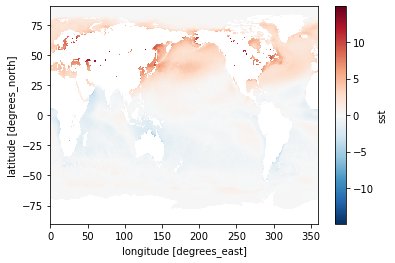

In [32]:
comp_diff.plot()

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


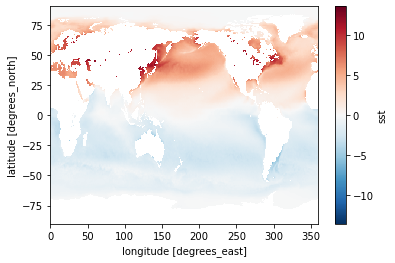

In [29]:
composites_early_onset.plot()

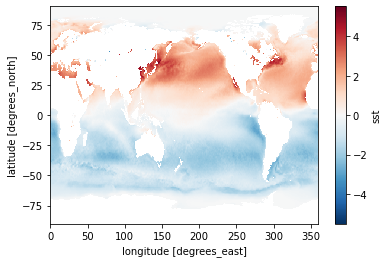

In [30]:
composites_late_onset.plot()

In [ ]:
composites_early_demise = create_composites(sst_anom, early_demise_dates, period=4)
composites_late_demise = create_composites(sst_anom, late_demise_dates, period=4)

In [ ]:
pp.plot_spatial_data(composites_early_demise,vmin=-50, vmax=50, cmap='RdBu_r', var='Geopotential Anomaly', title='Early Demise Composite')

In [ ]:
pp.plot_spatial_data(composites_late_demise,vmin=-40, vmax=40, cmap='RdBu_r', var='Geopotential Anomaly', title='Late Demise Composite')

In [ ]:


def create_composites(ds, dates, period):
    composites = {}
    composite_data = []
    for date in dates:
        start_date = date - pd.Timedelta(period,'w')
        end_date = date - pd.Timedelta(1,"d")
        
        subset = ds.sel(time=slice(start_date, end_date))
        
        composite = subset.mean(dim='time')
        composite_data.append(composite)
    
    composites = xr.concat(composite_data, dim='time')
    composites = composites.mean(dim='time')
    return composites

# Create composites for each time period
#composites_1week = create_composites(ds, dates, period='1w')
#composites_2weeks = create_composites(ds, dates, period='2w')
#composites_3weeks = create_composites(ds, dates, period='3w')
#composites_1month = create_composites(ds, dates, period='1M')

In [ ]:
late_dates